In [381]:
"""

1. Comparing surface height changes in AWS vs. MERRA snowfall in Spring.

"""

# Import libraries
import glob
import os
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import pandas as pd
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# Define base path
path = '/Users/jryan4/Dropbox (University of Oregon)/research/snowfall/data/'

In [792]:
stations = ['KAN_M', 'THU_L', 'TAS_L']

start_month = '03'
end_month = '04'

In [793]:
merra_sf_all = []
aws_height_all = []

for station in stations:   

    # Import AWS data 
    aws = pd.read_csv(path + 'promice/' + station + '_day_v03.txt', sep='\s+')

    # Find coordinates
    aws_coords = pd.read_csv(path + 'promice/aws_coordinates.csv')
    idx = list(aws_coords['Name']).index(station)

    # Read optimal DOY data
    doy = pd.read_csv(path + 'optimal_doy.csv')
    
    aws['datetime'] = pd.to_datetime(dict(year=aws['Year'], month=aws['MonthOfYear'], day=aws['DayOfMonth']))
    aws.set_index('datetime', inplace=True)
    
    # Get first year of AWS data
    start = aws.index[0].year
    end = aws.index[-1].year
    
    # Remove rows with NaNs
    aws = aws[aws['HeightSensorBoom(m)'] != -999]
    aws = aws[aws['TiltToEast(d)'] != -999]
    aws = aws[aws['TiltToNorth(d)'] != -999]
    
    # Correct for tilt
    east_radians = np.deg2rad(aws['TiltToEast(d)'])
    north_radians = np.deg2rad(aws['TiltToNorth(d)'])

    X = np.cos(east_radians) * np.sin(north_radians)
    Y = np.sin(east_radians)
    Z = np.cos(east_radians) * np.cos(north_radians)

    zenith = np.arctan(np.sqrt(X**2 + Y**2) / Z)

    aws['height'] = aws['HeightSensorBoom(m)'] / np.cos(zenith)
    
    # Get corresponding MERRA data
    years = np.arange(start, end + 1)
    
    merra_files = []
    for file in sorted(glob.glob(path + 'merra_snowfall_modern/ablation_snowfall_*.nc')):
        if int(os.path.basename(file)[18:22]) in years:
            merra_files.append(file)
            
    
    merra_snow = []
    for file in merra_files:
        # Find corresponding MERRA data
        merra = xr.open_dataset(file)

        # Find nearest grid cell
        coords = np.vstack((merra['longitude'].values, merra['latitude'].values)).T
        pt = aws_coords['Longitude'].iloc[idx], aws_coords['Latitude'].iloc[idx]
        distance, index = spatial.KDTree(coords).query(pt)

        merra_snow.append(merra['snowfall'][:, index].values)
        
    merra_snow_flat = [item for sublist in merra_snow for item in sublist]
    
    # Put into DataFrame
    merra_df = pd.DataFrame(list(zip(pd.date_range(start = '1/1/' + str(start), end='12/31/' + str(end)), merra_snow_flat)))
    merra_df.columns = ['datetime', 'snowfall']
    merra_df.set_index('datetime', inplace=True)
    
    # Combine DataFrames
    df = merra_df.join(aws, how='outer')
    
    # Perform filter (i.e. remove if two standard deviations from mean)
    rolling_mean = df['height'].rolling(window=11, min_periods=1, center=True).mean()
    rolling_std = df['height'].rolling(window=11, min_periods=1, center=True).std()
    rolling_std = rolling_std * 2

    # Calculate difference between original value and rolling mean
    difference = np.abs(df['height'] - rolling_mean)

    # Mask values that are more than two standard deviations from the mean
    mask = (difference < rolling_std)

    # Calculate 11-day rolling median to be used as the timeseries
    df['height_smooth'] = df['height'].where(mask == True).rolling(window=11, min_periods=3, center=True).median()

    merra_sf = []
    aws_height = []
    for year in years:

        date1 = str(year) + '-' + start_month + '-01'
        date2 = str(year) + '-' + end_month + '-01'

        # Check whether enough AWS data
        if df['height'][date1:date2].sum() > 28:
            aws_change = df['height_smooth'][date1:date2][-1] - df['height'][date1:date2][0]
            aws_height.append(aws_change)
            merra_snow = np.cumsum(df['snowfall'][date1:date2])[-1] - np.cumsum(df['snowfall'][date1:date2])[0]
            merra_sf.append(merra_snow)
        else:
            pass
    
    merra_sf_all.append(merra_sf)
    aws_height_all.append(aws_height)

In [794]:
a = [item for sublist in merra_sf_all for item in sublist]
b = [item for sublist in aws_height_all for item in sublist]

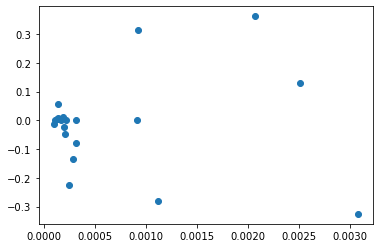

In [795]:
plt.scatter(a, b)

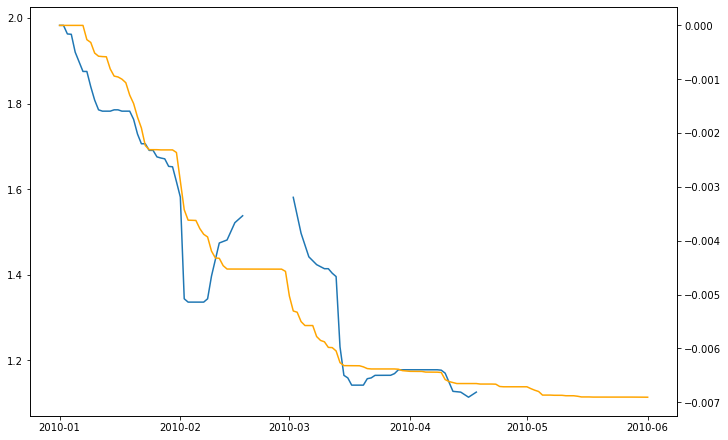

In [775]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), layout='constrained')
ax1.plot(df['height_smooth'][date1:date2])
ax2 = ax1.twinx()
ax2.plot(np.cumsum(df['snowfall'][date1:date2] * -1), color='orange')

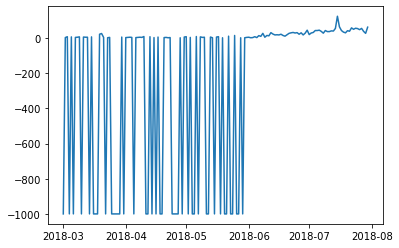

In [802]:
plt.plot(aws['AblationPressureTransducer(mm)']['2018-03-01':'2018-07-30'])

In [797]:
aws.columns

Index(['Year', 'MonthOfYear', 'DayOfMonth', 'DayOfYear', 'DayOfCentury',
       'AirPressure(hPa)', 'AirTemperature(C)', 'AirTemperatureHygroClip(C)',
       'RelativeHumidity(%)', 'SpecificHumidity(g/kg)', 'WindSpeed(m/s)',
       'WindDirection(d)', 'SensibleHeatFlux(W/m2)', 'LatentHeatFlux(W/m2)',
       'ShortwaveRadiationDown(W/m2)', 'ShortwaveRadiationDown_Cor(W/m2)',
       'ShortwaveRadiationUp(W/m2)', 'ShortwaveRadiationUp_Cor(W/m2)',
       'Albedo_theta<70d', 'LongwaveRadiationDown(W/m2)',
       'LongwaveRadiationUp(W/m2)', 'CloudCover', 'SurfaceTemperature(C)',
       'HeightSensorBoom(m)', 'HeightStakes(m)', 'DepthPressureTransducer(m)',
       'DepthPressureTransducer_Cor(m)', 'AblationPressureTransducer(mm)',
       'IceTemperature1(C)', 'IceTemperature2(C)', 'IceTemperature3(C)',
       'IceTemperature4(C)', 'IceTemperature5(C)', 'IceTemperature6(C)',
       'IceTemperature7(C)', 'IceTemperature8(C)', 'TiltToEast(d)',
       'TiltToNorth(d)', 'LatitudeGPS_HDOP<1(degN)'